## Machine Learning & AI

![Colegio Bourbaki](./Images/Bourbaki.png)

### Deep Reinforcement Learning

Este proyecto aprovecha un modelo de aprendizaje profundo de IA para optimizar y reducir el consumo energético de un centro de datos hasta en un 70%. El modelo de IA utiliza el algoritmo PPO para determinar la mejor acción en cada paso temporal. PPO es un algoritmo on-policy.

El proyecto pretende reducir el consumo energético de una instalación industrial. Se utiliza un modelo de optimización de aprendizaje profundo y se compara con el sistema de refrigeración integrado tradicional. El enfoque se inspira en la reducción del 40% lograda en los centros de datos de Google utilizando el modelo de IA de DeepMind. El proyecto forma parte del módulo Artificial Intelligence for Business de Udemy.

**En este escenario, hay dos supuestos clave:**

* La temperatura intrínseca de un servidor es una función de la temperatura atmosférica, el número de usuarios en el servidor y la velocidad de transmisión de datos. La relación se aproxima mediante una combinación lineal de esas 3 variables. Los coeficientes se estiman mediante un análisis de regresión.

* La energía gastada para regular la temperatura entre dos pasos temporales es proporcional al cambio absoluto de temperatura. Utilizando esta relación lineal, podemos estimar que el consumo de energía de cada mecanismo es proporcional al cambio absoluto de temperatura del servidor. Esto se aplica tanto al sistema de IA como al sistema de refrigeración integrado tradicional.

## PPO (Proximal Policy Optimization)

**PPO** es un algoritmo de Aprendizaje por Refuerzo basado en gradiente de políticas que optimiza directamente una política estocástica $(\pi_\theta(a\mid s))$ sin necesidad de un modelo del entorno.  
En lugar de aprender valores $(Q(s,a))$ como Q-Learning, PPO maximiza un objetivo *proximal* que limita cambios bruscos en la política mediante *clipping* del ratio de probabilidades, y usa un crítico $(V_\phi(s))$ para reducir la varianza de los gradientes.
En nuestro proyecto, el agente controla un ajuste de temperatura continuo $(\Delta T)$ acotado con $(\tanh)$ a $([-\text{max\_delta},+\text{max\_delta}])$.

Esto asegura que las acciones propuestas siempre estén dentro de los límites físicos permitidos.

La recompensa por paso combina el **ahorro energético frente a un baseline No-AI** (que clampea a la banda óptima).

### Entrenamiento con PPO
1. **Recolectar** una trayectoria con la política actual: $((s_t,a_t,r_t,\log\pi(a_t|s_t),V(s_t),\text{done}))$.  
2. **Calcular** ventajas $(\hat{A}_t)$ con **GAE(λ)** y retornos $(\hat{R}_t)$; *bootstrap* con $(V(s_T))$ si el episodio no terminó.  
3. **Optimizar** varios *epochs* sobre minibatches con el objetivo **clipped** de PPO:  

$
\mathcal{L}_{\text{actor}}^{\text{CLIP}}
= \mathbb{E}_t\Big[\min\big(r_t(\theta)\,\hat{A}_t,\;
\text{clip}(r_t(\theta),1-\varepsilon,1+\varepsilon)\,\hat{A}_t\big)\Big]
$

### Ventajas de PPO
- Soporta **acciones continuas** con límites físicos $(\tanh)$.  
- Es **estable** y sample-efficient gracias a *clipping* y **GAE**.

El proyecto utiliza una red neuronal **actor-crítico** sencilla formada por capas totalmente conectadas.  
La entrada es un **vector de estado normalizado** que incluye características importantes.
El estado se actualiza en cada paso temporal y captura las condiciones actuales del sistema.

### Actor (política)
- Capas ocultas con activación **ReLU**.  
- Una capa de salida que produce la **media** de una distribución gaussiana de una acción continua $(\Delta T)$.  
- La acción final se obtiene muestreando de la distribución y aplicando una función **tanh** para acotarla a $([-\text{max\_delta},+\text{max\_delta}])$.

### Crítico (función de valor)
- Red con la misma arquitectura de entrada y ocultas.  
- La salida es un **único valor escalar** que estima $(V(s))$, el valor esperado del estado.

### Entrenamiento con PPO
- El **actor** se entrena maximizando la probabilidad de las acciones que dieron ventajas positivas, con el **objetivo clippeado** para evitar cambios bruscos en la política.  
- El **crítico** se entrena minimizando el error cuadrático entre sus predicciones y los retornos observados (con o sin *value clipping*).  
- En lugar de *Experience Replay* (usado en Q-Learning), se emplea un **buffer de rollouts on-policy**, que se limpia tras cada actualización.  


### Librerías

In [1]:
# PPO
import torch
import torch.nn as nn
from torch.distributions import Normal, TransformedDistribution
from torch.distributions.transforms import TanhTransform, AffineTransform

#Utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

### Ambiente

El siguiente código define un entorno simulado para un escenario de aprendizaje por refuerzo (RL) en el que el objetivo es gestionar la temperatura de una sala de servidores de forma eficiente mediante el uso de inteligencia artificial (IA). Simula la dinámica del entorno, incluidos los cambios de temperatura debidos a las condiciones atmosféricas, el número de usuarios y la velocidad de procesamiento de datos, que en conjunto influyen en la temperatura de la sala de servidores. El agente de IA interactúa con este entorno realizando acciones para ajustar el sistema de refrigeración del servidor, con el objetivo de mantener la temperatura dentro de un rango óptimo. La eficacia de estas acciones se evalúa mediante un sistema de recompensas que penaliza el uso excesivo de energía y recompensa la gestión eficiente de la temperatura.

La clase Environment encapsula todos los parámetros, variables y métodos necesarios para simular el escenario de gestión de la temperatura de la sala de servidores. Desglosemos los métodos:

**__init__:**

Inicializa el entorno con los siguientes parámetros:

* optimal_temperature: El rango de temperatura objetivo para la sala de servidores.
* initial_month: El mes inicial, que afecta a la temperatura ambiente.
* initial_number_users: El número inicial de usuarios que utilizan los recursos del servidor.
* initial_rate_data: La tasa inicial de datos que procesa el servidor.

Estos parámetros influyen en el estado inicial del entorno, incluyendo la temperatura atmosférica, la temperatura intrínseca de la sala del servidor (basada en los usuarios actuales y la tasa de datos), y la temperatura inicial establecida por los sistemas AI y no AI.

**step:**

Simula el efecto de una acción realizada por la IA para ajustar la temperatura. Actualiza el estado del entorno en función de la dirección y la magnitud de la acción, el cambio en el número de usuarios y la velocidad de procesamiento de datos. También calcula la nueva recompensa basándose en la energía utilizada por la IA y el sistema no IA, actualiza la temperatura de la sala del servidor y comprueba si el juego ha terminado debido a que la temperatura ha caído fuera del rango permitido.

**reset:**

Reinicia el entorno a un mes especificado, reinicializando la temperatura atmosférica y otras variables de estado a sus valores iniciales. Este método se utiliza para iniciar un nuevo episodio en el contexto RL.

**observe:**

Proporciona el estado actual del entorno al agente de la IA. Esto incluye las versiones escaladas de la temperatura del servidor, el número de usuarios y la tasa de procesamiento de datos, junto con la última recompensa recibida y si el proceso ha terminado.

In [ ]:
class Environment:
    def __init__(
        self,
        optimal_temperature=(18.0, 24.0),
        initial_month=0,
        initial_number_users=10,
        initial_rate_data=60,
        max_delta=5.0,   # per-step action cap
    ):
        # Initialize environment parameters
        self.initial_month = initial_month
        self.monthly_atmospheric_temperatures = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0, 23.0, 24.0, 22.0, 10.0, 5.0, 1.0]
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[initial_month]
        self.optimal_temperature = optimal_temperature
        self.opt_low = optimal_temperature[0]
        self.opt_high = optimal_temperature[1]
        self.min_temperature = -20
        self.max_temperature = 80
        # Initialize user limits
        self.min_number_users = 10
        self.max_number_users = 100
        self.max_update_users = 5
        self.initial_number_users = initial_number_users
        self.current_number_users = initial_number_users
        # Initialize data limits
        self.min_rate_data = 20
        self.max_rate_data = 300
        self.max_update_data = 10
        self.initial_rate_data = initial_rate_data
        self.current_rate_data = initial_rate_data
        # Initialize intrinsic temperatures
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users \
                                     + 1.25 * self.current_rate_data
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = (self.optimal_temperature[0] + self.optimal_temperature[1]) / 2.0  # mid of band
        # Initialize energy variables
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        # Initialize reward and game state
        self.reward = 0.0
        self.game_over = 0
        self.train = 1

        self.max_delta = float(max_delta)          # action bound
        self.previous_action = 0.0                 # last (bounded) action

        self.reset(new_month=initial_month)

    def reset(self, new_month):
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[new_month]
        self.initial_month = new_month
        self.current_number_users = self.initial_number_users
        self.current_rate_data = self.initial_rate_data
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users \
                                     + 1.25 * self.current_rate_data
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = (self.optimal_temperature[0] + self.optimal_temperature[1]) / 2.0
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        self.reward = 0.0
        self.game_over = 0
        self.train = 1
        self.previous_action = 0.0


    def observe(self):
        eps = 1e-8  # avoid divide-by-zero everywhere
        # normalize previous_action from [-max_delta, +max_delta] → [0,1]
        maxd = float(self.max_delta) if np.isfinite(self.max_delta) else 0.0
        if maxd <= 0.0:
            prev_action_01 = 0.5  # neutral if misconfigured
        else:
            prev_action_01 = ((self.previous_action / (maxd + eps)) + 1.0) * 0.5
        obs = np.array([
            (self.temperature_ai   - self.min_temperature) / (self.max_temperature - self.min_temperature + eps),
            (self.temperature_noai - self.min_temperature) / (self.max_temperature - self.min_temperature + eps),
            (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users + eps),
            (self.current_rate_data   - self.min_rate_data)   / (self.max_rate_data   - self.min_rate_data   + eps),
            (self.atmospheric_temperature - min(self.monthly_atmospheric_temperatures)) /
                (max(self.monthly_atmospheric_temperatures) - min(self.monthly_atmospheric_temperatures) + eps),
            (self.intrinsic_temperature - self.min_temperature) / (self.max_temperature - self.min_temperature + eps),
            prev_action_01
        ], dtype=np.float32)

        return obs, self.reward, self.game_over

    def step(self, action, month):
        # --- 1) Bounded action & energy ---
        delta_temperature_ai = float(np.clip(action, -self.max_delta, self.max_delta))
        self.previous_action = delta_temperature_ai
        energy_ai = abs(delta_temperature_ai)

        # --- 2) NoAI baseline BEFORE dynamics ---
        opt_low, opt_high = self.optimal_temperature
        energy_noai = 0.0
        if self.temperature_noai < opt_low:
            energy_noai = opt_low - self.temperature_noai
            self.temperature_noai = opt_low
        elif self.temperature_noai > opt_high:
            energy_noai = self.temperature_noai - opt_high
            self.temperature_noai = opt_high

        # Core objective: save energy vs. baseline
        self.reward = 1e-3 * (energy_noai - energy_ai)

        # --- 3) Exogenous changes---
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[month]
        self.current_number_users += np.random.randint(-self.max_update_users, self.max_update_users + 1)
        self.current_number_users = np.clip(self.current_number_users, self.min_number_users, self.max_number_users)
        self.current_rate_data += np.random.randint(-self.max_update_data, self.max_update_data + 1)
        self.current_rate_data = np.clip(self.current_rate_data, self.min_rate_data, self.max_rate_data)

        past_intrinsic_temperature = self.intrinsic_temperature
        self.intrinsic_temperature = (
            self.atmospheric_temperature +
            1.25 * self.current_number_users +
            1.25 * self.current_rate_data
        )
        delta_intrinsic = self.intrinsic_temperature - past_intrinsic_temperature

        # --- 4) Dynamics ---
        self.temperature_ai   += delta_intrinsic + delta_temperature_ai
        self.temperature_noai += delta_intrinsic

        # --- 5) Tracking cost on the RESULTING state ---
        T = self.temperature_ai
        if   T < opt_low:
            dist = opt_low - T
        elif T > opt_high:
            dist = T - opt_high
        else:
            dist = 0.0

        # smoothed penalty
        # self.reward += -0.6 * dist            # L1 pull
        # self.reward += -0.02 * (dist ** 2)    # L2 stabilizer
        # self.reward += -1e-3 * (delta_temperature_ai ** 2)  # optional action smoothness

        # --- 6) Overflow handling (training vs eval) ---
        overflow = None
        if T < self.min_temperature:
            overflow = self.min_temperature - T
        elif T > self.max_temperature:
            overflow = T - self.max_temperature

        if overflow is not None:
            if self.train:
                # scaled terminal penalty; end episode now
                self.reward += - 1.0 * (overflow ** 2)
                self.game_over = True
                obs, _, _ = self.observe()
                return obs, float(self.reward), bool(self.game_over)
            else:
                # evaluation: account energy, snap back toward comfort band
                if T < self.min_temperature:
                    self.total_energy_ai += opt_low - T
                    self.temperature_ai = opt_low
                else:
                    self.total_energy_ai += T - opt_high
                    self.temperature_ai = opt_high

        # --- 7) Energy accounting ---
        self.total_energy_ai   += energy_ai
        self.total_energy_noai += energy_noai

        # optional: clamp for plotting readability in eval
        if not self.train:
            self.temperature_ai = np.clip(self.temperature_ai, self.min_temperature, self.max_temperature)

        obs, _, _ = self.observe()
        return obs, float(self.reward), bool(self.game_over)

**Dinámica de simulación:**

El entorno simula la dinámica de una sala de servidores en la que la temperatura puede variar en función de las condiciones externas (temperatura atmosférica), la carga interna (número de usuarios y velocidad de datos) y las intervenciones de la IA (ajustes en el sistema de refrigeración). El objetivo de la IA es gestionar estas dinámicas para mantener la temperatura dentro de un rango óptimo, minimizando el consumo de energía y evitando al mismo tiempo el sobrecalentamiento o la refrigeración excesiva.

**Contexto de aprendizaje por refuerzo:**

Este entorno simulado está diseñado para entrenar a un agente de IA mediante aprendizaje por refuerzo. El agente aprende a realizar acciones (ajustar la temperatura de la sala de servidores) basándose en el estado actual del entorno para maximizar la recompensa acumulada a lo largo del tiempo. El mecanismo de recompensa anima al agente a mantener la temperatura dentro del rango óptimo con un uso mínimo de energía, equilibrando el compromiso entre la eficiencia energética y la gestión eficaz de la temperatura.

### Red Neuronal

In [5]:
# Actor-Critic for continuous action space
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, max_delta=5.0):
        super().__init__()
        self.max_delta = max_delta
        self.actor_mean = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.actor_log_std = nn.Parameter(torch.zeros(1))  # shared log std
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        mean = self.actor_mean(x)
        log_std = torch.clamp(self.actor_log_std, -5, 1)
        std = torch.exp(log_std).expand_as(mean)  # same std for all actions
        base = Normal(mean, std)
        # squash to [-1, 1], then scale to [-max_delta, max_delta]
        transforms = [TanhTransform(cache_size=1), AffineTransform(loc=0., scale=self.max_delta)]
        dist = TransformedDistribution(base, transforms)
        value = self.critic(x)
        return dist, value


In [6]:
class RolloutBuffer:
    def __init__(self):
        self.clear()

    def clear(self):
        self.states, self.actions, self.rewards = [], [], []
        self.log_probs, self.dones, self.values = [], [], []

    def add(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

### Implementación

## Clase `PPOAgent` (Proximal Policy Optimization)

En **PPO**, a diferencia de DQN, no usamos *Experience Replay* con Q-valores. En su lugar, entrenamos **on-policy** una **política estocástica** (actor) y un **crítico** $V(s)$ a partir de **trayectorias recientes** (*rollouts*). La clase `PPOAgent` gestiona:
1) la **recolección** de transiciones,  
2) el **cálculo de ventajas** con **GAE(λ)**,  
3) y la **optimización** con el objetivo *clipped* de PPO (más entropía y pérdida del crítico).


### Estructura general

- **Actor–Crítico** (en `ActorCritic`):
  - **Actor**: produce una media $\mu(s)$ y un desvío $\sigma$ de una Gaussiana; la acción se **acota** con `tanh` a $[-\text{max\_delta},+\text{max\_delta}]$.
  - **Crítico**: estima $V(s)$ (valor del estado).
- **Buffer on-policy** (`RolloutBuffer`): guarda $(s_t, a_t, r_t, \log \pi(a_t|s_t), V(s_t), done)$ de la **política actual**. Se vacía tras cada actualización (no se re-muestrea como en Replay).


### Métodos principales

#### `__init__(...)`
Configura:
- **modelo** `ActorCritic(state_dim, hidden_dim, max_delta)`,  
- **optimizador** (p. ej. Adam para actor y crítico, con LR del crítico algo menor),  
- hiperparámetros PPO: $\gamma$, $\lambda$, $\varepsilon$ de *clip*, `epochs`, `batch_size`,   
- **dispositivo** (CPU/GPU) robusto.  

#### `select_action(state)`
- Convierte el estado a tensor y **muestra** una acción de la política actual.  
- Devuelve: `action` (escalar continuo $\Delta T$), `log_prob` (log-probabilidad de la acción bajo la política), y `value` $V(s)$ del crítico.  
- Nota: sumamos las log-probabilidades a lo largo de la dimensión de acción. La salida ya está **tanh-squashed** y escalada por `max_delta`.

#### `remember(state, action, reward, done, log_prob, value)`
- **Almacena** la transición en el **buffer on-policy** para la posterior actualización.

#### `compute_gae(last_value)`
- Calcula **ventajas** $\hat{A}_t$ con **GAE(λ)** y **retornos** $\hat{R}_t$.  
- Usa `last_value` para **bootstrap** si el episodio se cortó por horizonte (no terminal).  
  - Si `done=True` en el último paso → `last_value = 0.0`.  
  - Si se cortó por horizonte → `last_value = V(s_{\text{final}})`.

#### `train_on_batch(last_value)`
- 1) Llama a `compute_gae(last_value)`.  
- 2) Construye tensores: estados, acciones, ventajas (normalizadas), retornos y `old_log_probs`.  
- 3) Ejecuta **varios *epochs*** sobre **minibatches**:
  - **Actor (PPO-clip)**: maximiza  
    $$
    \mathbb{E}\big[\min(r_t\hat{A}_t,\ \text{clip}(r_t,1-\varepsilon,1+\varepsilon)\hat{A}_t)\big], \quad
    r_t = \exp(\log\pi_{\text{new}} - \log\pi_{\text{old}})
    $$
  - **Crítico**: MSE $(V(s) - \hat{R})^2$ o **value clipping** (opcional) para evitar saltos grandes del valor.  
  - **Entropía**: término de regularización para mantener exploración; con políticas *tanh-squashed* se calcula por **estimación Monte Carlo**:  
    $\hat{\mathcal{H}} \approx -\mathbb{E}[\log \pi(a|s)]$ usando `rsample()`.  
  - **Clip de gradiente** (p. ej. 1.0) y **early stop por KL** aproximado (si sobrepasa `target_kl`).  

- 4) **Limpia** el buffer (`buffer.clear()`).  

### Bucles de uso (esquema)

**Recolección (por época):**
1. Reset env → `state`.  
2. Mientras no `done` y no supere horizonte:  
   - `(action, logp, value) = select_action(state)`  
   - `next_state, reward, done = env.step(action, month)`  
   - `remember(state, action, reward, done, logp, value)`  
   - `state = next_state`  
3. `last_value = 0.0` si terminal; si no terminal → $V(state)$.  

**Actualización:**
- `train_on_batch(last_value)` → optimiza actor y crítico, limpia buffer.  

> Resultado: una política continua y acotada que aprende a **ahorrar energía** frente a un baseline No-AI, a la vez que mantiene la temperatura dentro de la banda óptima.


In [ ]:
class PPOAgent:
    def __init__(self, state_dim, hidden_dim, max_delta, gamma=0.99, lam=0.95, clip_eps=0.2, lr=3e-4, batch_size=64, epochs=8, device='gpu'):
        self.model = ActorCritic(state_dim, hidden_dim, max_delta).to(device)
        self.optimizer = torch.optim.AdamW([
            {'params': self.model.actor_mean.parameters(), 'lr': lr},
            {'params': self.model.critic.parameters(), 'lr': lr * 0.5}
        ], weight_decay=lr*0.1, amsgrad=True)
        self.device = device
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.batch_size = batch_size
        self.epochs = epochs
        self.buffer = RolloutBuffer()
     # -------- action selection --------
    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            dist, value = self.model(state_tensor)              # (B, 1) action dim
            action = dist.sample()                               # (1, 1)
            log_prob = dist.log_prob(action).sum(-1)            # (1,) sum over action dim
        return action.squeeze(0).item(), log_prob.item(), value.squeeze(0).item()
    # -------- storage --------
    def remember(self, state, action, reward, done, log_prob, value):
        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.rewards.append(reward)
        self.buffer.dones.append(done)
        self.buffer.log_probs.append(log_prob)
        self.buffer.values.append(value)
    # -------- GAE with last-value bootstrapping --------
    def compute_gae(self, last_value):
        values = self.buffer.values + [last_value]
        advantages, returns = [], []
        gae = 0
        for t in reversed(range(len(self.buffer.rewards))):
            delta = self.buffer.rewards[t] + self.gamma * values[t + 1] * (1 - self.buffer.dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - self.buffer.dones[t]) * gae
            advantages.insert(0, gae)
            returns.insert(0, gae + values[t])
        return advantages, returns

    def train_on_batch(self, last_value):
        advantages, returns = self.compute_gae(last_value)

        states = torch.tensor(np.array(self.buffer.states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(np.array(self.buffer.actions), dtype=torch.float32).unsqueeze(1).to(self.device)
        old_log_probs = torch.tensor(np.array(self.buffer.log_probs), dtype=torch.float32).unsqueeze(1).to(self.device)
        returns = torch.tensor(np.array(returns), dtype=torch.float32).unsqueeze(1).to(self.device)
        advantages = torch.tensor(np.array(advantages), dtype=torch.float32).unsqueeze(1).to(self.device)
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        else:
            advantages = advantages - advantages.mean()  # no division to avoid warning

        for _ in range(self.epochs):
            idx = np.random.permutation(len(states))
            for start in range(0, len(states), self.batch_size):
                i = idx[start:start + self.batch_size]

                dist, values = self.model(states[i])                        # values: (B,1)
                log_probs = dist.log_prob(actions[i]).sum(-1, keepdim=True) # (B,1)
                # policy ratio
                ratio = torch.exp(log_probs - old_log_probs[i])             # (B,1)
                surr1 = ratio * advantages[i]
                surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages[i]
                actor_loss = -torch.min(surr1, surr2).mean()
                v_pred = values
                v_old  = returns[i] - advantages[i]       # old value estimate (from rollout)
                v_clipped = v_old + (v_pred - v_old).clamp(-self.clip_eps, self.clip_eps)
                vf_loss1 = (v_pred   - returns[i]).pow(2)
                vf_loss2 = (v_clipped - returns[i]).pow(2)
                critic_loss = torch.max(vf_loss1, vf_loss2).mean()
                # critic_loss = (returns[i] - values).pow(2).mean() ## if no clipping in the value...

                loss = actor_loss + 0.5 * critic_loss
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()

        self.buffer.clear()

### Parámetros

In [8]:
# PPO training parameters
number_epochs = 10000
state_dim = 7
hidden_dim = 64
batch_size = 512
learning_rate = 1e-5
epochs_ppo = 8
clip_epsilon = 0.2
gamma = 0.99
lam = 0.95

### Entrenamiento

In [9]:
# CREATE ENVIRONMENT & AGENT
max_delta = 1.5

env = Environment(
    optimal_temperature=(18.0, 24.0),
    initial_month=0,
    initial_number_users=20,
    initial_rate_data=30,
    max_delta=max_delta
)

ppo_agent = PPOAgent(
    state_dim=state_dim,
    hidden_dim=hidden_dim,
    max_delta=max_delta,
    lr=learning_rate,
    batch_size=batch_size,
    epochs=epochs_ppo,
    device=device.type
)

In [10]:
# CHOOSING THE MODE
train = True
env.train = train

# EARLY STOPPING SETUP
early_stopping = True
patience = 5000
patience_count = 0

In [11]:
# Store episode statistics
reward_history = []
energy_ai_history = []
energy_noai_history = []
actions_log = []
temperature_ai_log = []
temperature_noai_log = []
percentage_saved_log = []

In [12]:
if env.train:
    best_total_reward = -float('inf')
    patience_count = 0
    pbar = trange(number_epochs, desc="Training", unit="epoch")

    for epoch in pbar:
        total_reward = 0
        new_month = np.random.randint(0, 12)
        env.reset(new_month=new_month)

        state, _, done = env.observe()
        timestep = 0

        while not done and timestep <= 5 * 30 * 24 * 60:
            action, log_prob, value = ppo_agent.select_action(state)
            month = min(11, int(timestep / (30 * 24 * 60)))
            next_state, reward, done = env.step(action, month)
            # store transition 
            ppo_agent.remember(
                state=state,
                action=action,
                reward=reward,
                done=done,
                log_prob=log_prob,
                value=value
            )
            
            total_reward += reward
            timestep += 1
            state = next_state

            if done:
                # break immediately after storing terminal transition
                break
        
        if done:
            last_value = 0.0
        else:
            with torch.no_grad():
                last_value = ppo_agent.model(
                    torch.tensor(state, dtype=torch.float32, device=ppo_agent.device).unsqueeze(0)
                )[1].item()

        # === epoch logging for plots ===
        ppo_agent.train_on_batch(last_value)

        # Logging
        reward_history.append(total_reward)
        energy_ai_history.append(env.total_energy_ai)
        energy_noai_history.append(env.total_energy_noai)
        actions_log.append(action)
        temperature_ai_log.append(env.temperature_ai)
        temperature_noai_log.append(env.temperature_noai)
        percentage_saved_log.append(100 * (env.total_energy_noai - env.total_energy_ai) / (env.total_energy_noai + 1e-8))

        # Update progress bar description
        pbar.set_postfix({
            "Total Reward": f"{total_reward:.4f}",
            "Best Reward": f"{best_total_reward:.4f}",
            "AI Energy Spent": f"{env.total_energy_ai:.0f}",
            "NoAI Energy Spent": f"{env.total_energy_noai:.0f}",
            "Temperature AI": f"{env.temperature_ai:.2f}",
            "Temperature NoAI": f"{env.temperature_noai:.2f}",
            "Patience": patience_count,

        })

        # Early stopping
        if early_stopping:
            if total_reward <= best_total_reward:
                patience_count += 1
            else:
                best_total_reward = total_reward
                patience_count = 0
            if patience_count >= patience:
                print("Early Stopping triggered")
                break

        # Save model
        torch.save(ppo_agent.model.state_dict(), "./Data/model_ppo_continuous.pth")

Training: 100%|██████████| 10000/10000 [15:17<00:00, 10.90epoch/s, Total Reward=-15.9908, Best Reward=0.7854, AI Energy Spent=8, NoAI Energy Spent=39, Temperature AI=84.00, Temperature NoAI=30.25, Patience=3516]    


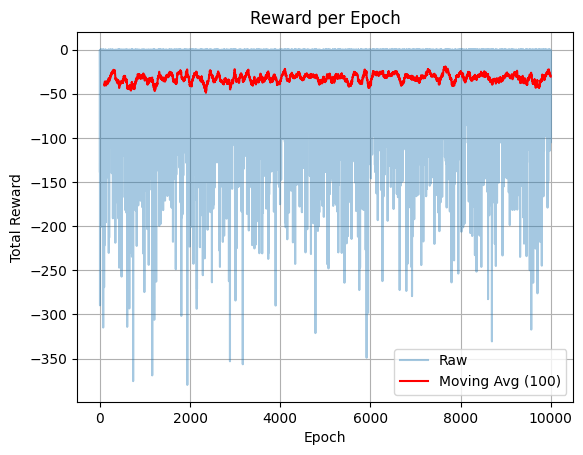

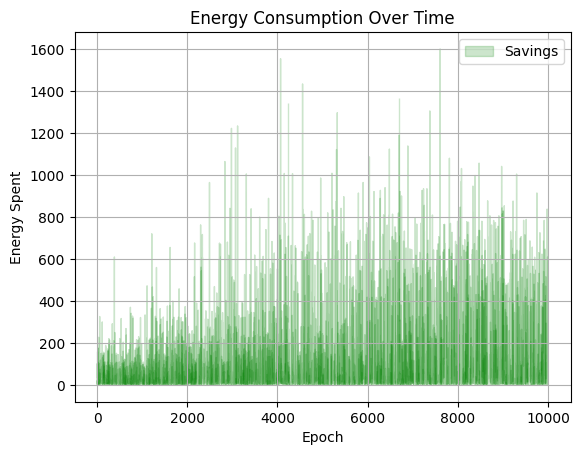

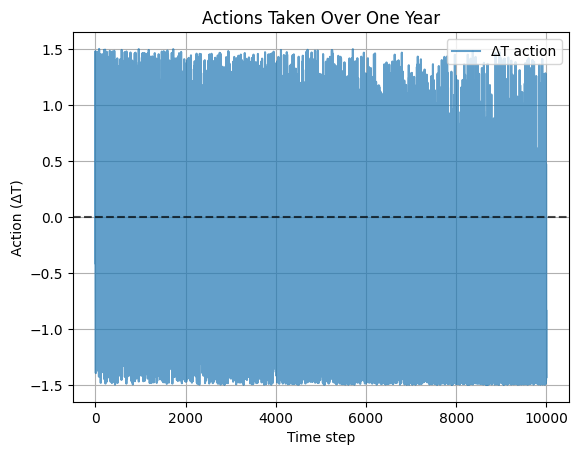

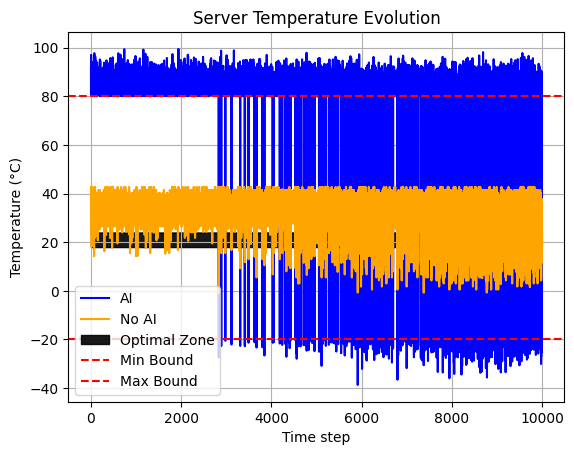

In [25]:
# ==== 2. PLOTTING RESULTS ====# 

# 1. Total Reward per Epoch
window = 100
smoothed = np.convolve(reward_history, np.ones(window)/window, mode="valid")
plt.figure()
plt.plot(reward_history, alpha=0.4, label="Raw")
plt.plot(range(window-1, len(reward_history)), smoothed, color="red", label=f"Moving Avg ({window})")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("Reward per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# 2. Energy Spent With and Without AI
plt.figure()
# plt.plot(energy_ai_history, label="AI", color="blue")
# plt.plot(energy_noai_history, label="No AI", color="orange")
plt.fill_between(range(len(energy_ai_history)),
                 energy_ai_history, energy_noai_history,
                 where=(np.array(energy_noai_history) > np.array(energy_ai_history)),
                 color="green", alpha=0.2, label="Savings")
plt.xlabel("Epoch")
plt.ylabel("Energy Spent")
plt.title("Energy Consumption Over Time")
plt.legend()
plt.grid(True)
plt.show()


# 4. Actions Over Time
plt.figure()
plt.plot(actions_log, alpha=0.7, label="ΔT action")
plt.axhline(y=0, color="black", linestyle="--", alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Action (ΔT)")
plt.title("Actions Taken Over One Year")
plt.legend()
plt.grid(True)
plt.show()

# 5. Temperature Evolution
plt.figure()
plt.plot(temperature_ai_log, label="AI", color="blue")
plt.plot(temperature_noai_log, label="No AI", color="orange")
# Optimal band
plt.fill_between(range(len(temperature_ai_log)),
                 env.optimal_temperature[0], env.optimal_temperature[1],
                 color="black", alpha=0.9, label="Optimal Zone")
# Boundaries
plt.axhline(y=env.min_temperature, color="red", linestyle="--", label="Min Bound")
plt.axhline(y=env.max_temperature, color="red", linestyle="--", label="Max Bound")
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Server Temperature Evolution")
plt.legend()
plt.grid(True)
plt.show()



### Evaluación de la performance del modelo

In [14]:
print("Evaluating one year of energy management...")

# --- Environment Setup ---
env = Environment(
    optimal_temperature=(18.0, 24.0),
    initial_month=0,
    initial_number_users=20,
    initial_rate_data=30,
    max_delta=max_delta
)


# --- Load PPO model ---
model = ActorCritic(state_dim, hidden_dim, max_delta).to(device)
state_dict = torch.load("./Data/model_ppo_continuous.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

# --- Evaluation Mode ---
env.train = False
state, _, _ = env.observe()

temp_ai_log, temp_noai_log, action_log = [], [], []

# --- Simulate 1 year (12 months * 30 days * 24 hours * 60 minutes) ---
for timestep in tqdm(range(12 * 30 * 24 * 60)):
    month = int(timestep / (30 * 24 * 60))

    # Convert state to tensor
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


    # Get action from policy (no gradient)
    with torch.no_grad():
        # dist, _ = model(state_tensor)
        # action = dist.mean.item()  # Use mean of distribution for deterministic policy
        base_mean = model.actor_mean(state_tensor)
        action = torch.tanh(base_mean).item() * model.max_delta

    # Apply action directly (continuous control)
    next_state, _, _ = env.step(action, month)
    state = next_state  # move to next state

    # logs (clipped only for chart readability)
    temp_ai_log.append(np.clip(env.temperature_ai, env.min_temperature, env.max_temperature))
    temp_noai_log.append(np.clip(env.temperature_noai, env.min_temperature, env.max_temperature))
    action_log.append(action)

# --- Results ---
print(f"Total Energy spent with an AI: {env.total_energy_ai:.0f}")
print(f"Total Energy spent with no AI: {env.total_energy_noai:.0f}")
print(f"ENERGY SAVED WITH AI: {(env.total_energy_noai - env.total_energy_ai) / env.total_energy_noai * 100:.0f}%")

Evaluating one year of energy management...


100%|██████████| 518400/518400 [03:01<00:00, 2859.68it/s]

Total Energy spent with an AI: 1495547
Total Energy spent with no AI: 2400993
ENERGY SAVED WITH AI: 38%


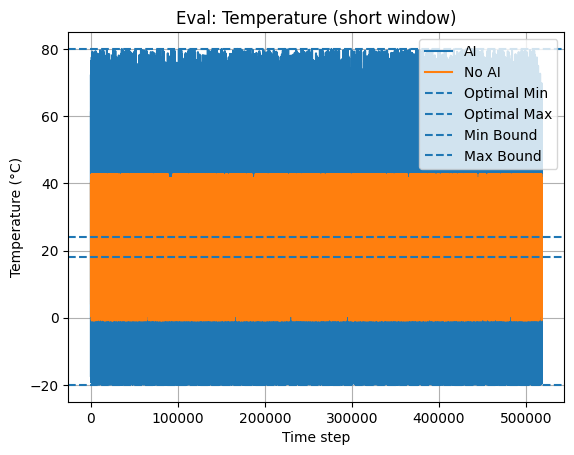

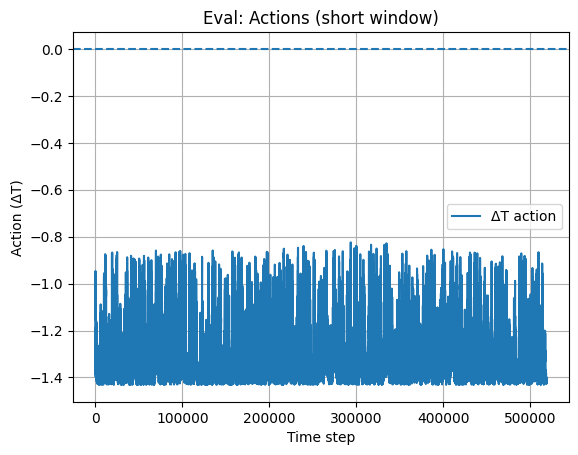

In [15]:
# --- Plot 1: Temperatures (short window) ---
plt.figure()
plt.plot(temp_ai_log, label="AI")
plt.plot(temp_noai_log, label="No AI")
plt.axhline(y=env.optimal_temperature[0], linestyle="--", label="Optimal Min")
plt.axhline(y=env.optimal_temperature[1], linestyle="--", label="Optimal Max")
plt.axhline(y=env.min_temperature, linestyle="--", label="Min Bound")
plt.axhline(y=env.max_temperature, linestyle="--", label="Max Bound")
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Eval: Temperature (short window)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Actions (short window) ---
plt.figure()
plt.plot(action_log, label="ΔT action")
plt.axhline(y=0.0, linestyle="--")
plt.xlabel("Time step")
plt.ylabel("Action (ΔT)")
plt.title("Eval: Actions (short window)")
plt.legend()
plt.grid(True)
plt.show()

### Resultados

El porcentaje de energía ahorrada varía en función de los experimentos. El porcentaje se determina simulando un ciclo anual completo. Ambos modelos pretenden mantener el servidor dentro de un rango de temperatura óptimo de 18° a 24°C. La simulación se realiza para pasos de tiempo de un minuto a lo largo de un año completo.

### Preguntas

**Conceptuales y Teóricas:**
* ¿Qué es PPO y cómo se diferencia del Q-Learning tradicional?
* Explica el concepto de "rollout buffer" en PPO. ¿Por qué es importante?
* ¿Qué papel juega la función de pérdida (loss function) en el entrenamiento de una red neuronal en PPO?
* Describe cómo la técnica de "buffer" mejora el proceso de aprendizaje en PPO.
* ¿Qué es el "clipping" en el contexto de PPO y cómo afecta al aprendizaje del agente?

**Sobre el Código y la Implementación:**
* En el código proporcionado para el problema de gestión energética, ¿cómo se determina la acción que debe tomar el agente en cada paso de tiempo?
* Describe cómo se actualiza el entorno después de que el agente toma una acción. ¿Qué información se utiliza para calcular el nuevo estado y la recompensa?
* Explica cómo se calcula la recompensa en este problema específico. ¿Qué incentivos y penalizaciones se consideran para el agente?
* ¿Cómo se maneja la exploración frente a la explotación en este problema de PPO?

**Aplicaciones y Análisis Crítico:**
* ¿Cuáles son las ventajas y desventajas de usar PPO en la gestión de la energía de un centro de datos?
* Considerando el problema de gestión energética, ¿qué modificaciones sugerirías para mejorar el rendimiento del modelo de PPO?
* Discute cómo cambiarías la arquitectura de la red neuronal para este problema específico y por qué.
* Analiza el impacto potencial de variar el tamaño del "rollout" y el "batch size" en el rendimiento del aprendizaje.
* ¿Cómo podrías modificar el problema para hacerlo más complejo o realista? ¿Qué cambios en el modelo o el algoritmo serían necesarios?

### Adaptado de: 

* https://github.com/LaurentVeyssier/Minimize-Energy-consumption-with-Deep-Learning-model/tree/main

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)